In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

In [2]:
users_cols = ['id', 'name']
ratings_cols = ['user_id', 'item_id', 'point']
item_cols = ['id', 'name']

from random import randrange

# user0 not voting any items
users = pd.DataFrame(data=[[i, 'user' + str(i)] for i in range(500)], index=None, columns=users_cols)
ratings = pd.DataFrame(data=[[randrange(1, 500), randrange(300), randrange(1, 5)] for i in range(8000)], index=None, columns=ratings_cols)
items = pd.DataFrame(data=[[i, 'item' + str(i)] for i in range(300)], index=None, columns=item_cols)

In [3]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [4]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'item_id']].values
  values = ratings_df['point'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], items.shape[0]])

In [5]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [6]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [7]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [8]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [9]:
def user_recommendations(model, id, measure=DOT, exclude_rated=False, k=6):
  scores = compute_scores(
      model.embeddings["user_id"][id], model.embeddings["item_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'item_id': items['id'],
      'name': items['name'],
  })
  if exclude_rated:
    # remove items that are already rated
    rated_items = ratings[ratings.user_id == id]["item_id"].values
    df = df[df.item_id.apply(lambda item_id: item_id not in rated_items)]
  display.display(df.sort_values([score_key], ascending=False).head(k))  

def item_neighbors(model, name_substring, measure=DOT, k=6):
  # Search for item ids that match the given substring.
  ids =  items[items['name'].str.contains(name_substring)].index.values
  titles = items.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no items with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching item. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  item_id = ids[0]
  scores = compute_scores(
      model.embeddings["item_id"][item_id], model.embeddings["item_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'item_id': items['id'],
      'name': items['name']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

 iteration 1000: train_error=0.030463, test_error=8.049312

[{'test_error': 8.049312, 'train_error': 0.030462964}]

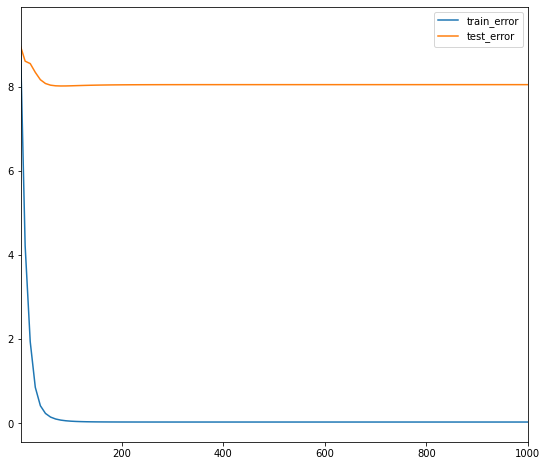

In [10]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [11]:
user_recommendations(model, 200, measure=COSINE, k=10)

,cosine score,item_id,name
271,0.402,271,item271
200,0.386,200,item200
117,0.369,117,item117
9,0.367,9,item9
8,0.367,8,item8
287,0.351,287,item287
87,0.349,87,item87
147,0.341,147,item147
79,0.337,79,item79
6,0.333,6,item6


In [12]:
user_recommendations(model, 200, measure=COSINE, k=10, exclude_rated=True)

,cosine score,item_id,name
271,0.402,271,item271
200,0.386,200,item200
9,0.367,9,item9
87,0.349,87,item87
147,0.341,147,item147
6,0.333,6,item6
128,0.312,128,item128
30,0.302,30,item30
22,0.300,22,item22
202,0.300,202,item202


In [13]:
item_neighbors(model, "item99", DOT)
item_neighbors(model, "item99", COSINE)

Nearest neighbors of : item99.


,dot score,item_id,name
99,8.926,99,item99
21,6.800,21,item21
169,5.362,169,item169
192,5.151,192,item192
231,5.124,231,item231
101,4.680,101,item101


Nearest neighbors of : item99.


,cosine score,item_id,name
99,1.000,99,item99
21,0.620,21,item21
169,0.557,169,item169
215,0.511,215,item215
192,0.502,192,item192
231,0.454,231,item231


In [14]:
user_recommendations(model, 0, measure=COSINE, k=10)

,cosine score,item_id,name
51,0.571,51,item51
124,0.437,124,item124
154,0.404,154,item154
93,0.399,93,item93
152,0.375,152,item152
191,0.370,191,item191
47,0.356,47,item47
280,0.348,280,item280
128,0.347,128,item128
287,0.343,287,item287
